In [19]:
import os 
import tarfile
import urllib
import pandas as pd
import matplotlib as plt
import numpy as np

In [20]:
#Pobieranie danych
Download_root = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
Housing_path = os.path.join("datasets","housing")
Housing_url = Download_root + "datasets/housing/housing.tgz"

def fetch_housing_data(url=Housing_url,h_path=Housing_path):
    os.makedirs(h_path, exist_ok=True)
    tgz_path = os.path.join(h_path, "housing.tgz")
    urllib.request.urlretrieve(url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=h_path)
    housing_tgz.close()

fetch_housing_data()

In [21]:
# Wyswietlanie danych
def load_housing_data(h_path=Housing_path):
    csv_path = os.path.join(h_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()
housing.head

<bound method NDFrame.head of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  ho

<module 'matplotlib.legend' from 'c:\\Users\\Adam\\anaconda3\\lib\\site-packages\\matplotlib\\legend.py'>

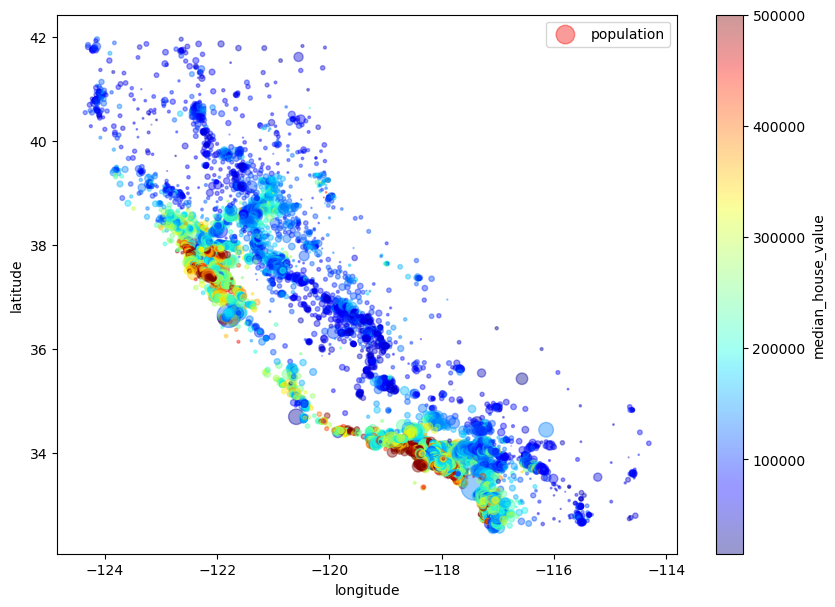

In [22]:
%matplotlib inline
#Whousing.hist(bins=50, figsize=(20,15))
housing.plot(kind='scatter', x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value",colormap='jet', colorbar=True
)
plt.legend

In [23]:
# Podział na Test Set and Training Set
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)
housing["income_cat"].value_counts() / len(housing)

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [24]:
# Szykowanie danych / data cleaning
'''
housing["rooms_per_houshold"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_houshold"] = housing["population"]/housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
'''
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()
#housing.dropna(subset=["total_bedrooms"]) usuwa dystrykty
#housing.drop("total_bedrooms",axis=1) usuwa caly atrybut
#median = housing["total_bedrooms"].median() #zastepuje brakujacy atrybut
#housing["total_bedrooms"].fillna(median, inplace=True)

# uzycie imputera do zastapienia brakujacych danych tylko na liczbach

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
#housing_tr.head()


In [25]:
housing_cat = housing[["ocean_proximity"]]
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()


# Transformator 
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
from sklearn.base import BaseEstimator, TransformerMixin
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)


# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)


In [26]:
housing.shape

(16512, 9)

In [27]:
# Trening
# Model liniowy
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predykcja:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predykcja: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [28]:
# Wyliczenie błędu
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse
# duzy błąd mało satysfakcjonujący, przykład modelu nie dopasowangeo do danych

68627.87390018743

In [29]:
# Model Drzewa Decyzyjnego
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse
# Błąd zero, czyli model nadpasowany prawdopodobnie

0.0

In [30]:
# Lepsza ewaluacja drzewa decyzyjnego
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)
scores_lin = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
rmse_scores_lin = np.sqrt(-scores_lin)
display_scores(rmse_scores_lin)

# Drzewo decyzyjne jest gorsze nawet po cross validacji

Scores: [72144.6518058  69161.90958854 68725.4772778  70895.77623775
 69880.02341846 78758.95313181 73280.10264496 71829.78988301
 68891.56588222 71545.12758109]
Mean: 71511.33774514325
Standard deviation: 2816.8109006921604
Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180634


In [31]:
# Ewaluacja modelu z użyciem random forest regressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51900.54670834 49195.71548582 46768.93597364 51579.39038916
 47385.07932401 52259.89529111 52620.42250114 49737.17624903
 48587.15166409 54093.93263728]
Mean: 50412.8246223632
Standard deviation: 2304.9080363821236


In [32]:
# Dostrajanie modelu
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [33]:
# Ewaluacja systemu na testowych danych
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_mse

2291849114.7652025